### IMPORTS
---

In [ ]:
## Install these packages if needeed
%pip install pandas
%pip install ydata-profiling
%pip install -U scikit-learn
%conda install -c conda-forge imbalanced-learn
%pip install Boruta

In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_csv, DataFrame
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from src.utils import get_model, train_model, test_model, save_model

import warnings 
warnings. filterwarnings('ignore')

### DATA
---

In [2]:
data = read_csv(filepath_or_buffer=".data/term-deposit-marketing-2020.csv")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [4]:
data.shape  # Note : not a small dataset

(40000, 14)

In [5]:
data.info()  # Good <> No missing-values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [6]:
data.describe(include="all")  # only numerical attributes considered
# 50 % of customers have less than 39 years old, have <= 407$ balance

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.000000,40000,40000,40000,40000,40000.000000,40000,40000,40000,40000.000000,40000,40000.000000,40000.000000,40000
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no
freq,NaN,9383,24386,20993,39191,NaN,24031,33070,24914,NaN,13532,NaN,NaN,37104
mean,40.544600,NaN,NaN,NaN,NaN,1274.277550,NaN,NaN,NaN,16.017225,NaN,254.824300,2.882175,NaN
std,9.641776,NaN,NaN,NaN,NaN,2903.769716,NaN,NaN,NaN,8.278127,NaN,259.366498,3.239051,NaN
min,19.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,54.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,407.000000,NaN,NaN,NaN,17.000000,NaN,175.000000,2.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1319.000000,NaN,NaN,NaN,21.000000,NaN,313.000000,3.000000,NaN


In [7]:
# Notes <> Attributes
# - marital : categorical, binary
# - education : categorical, ordinal
# - default : categorical, binary
# - housing : categorical, binary
# - loan : categorical, binary
# - month : categorical, ordinal
# - contact - categorical, multiple values possibles

In [54]:
data.value_counts(
    subset=["y"], normalize=True, dropna=True
).to_frame()  # Note : A huge data imbalance

,0
y,
no,0.9276
yes,0.0724


### EDA
----

In [9]:
profile = ProfileReport(
    df=data
)  # Note : duration is the feature with the highest correlation with y

In [10]:
profile.to_file(output_file=".data/eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
profile.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### MODELLING
---

In [3]:
from typing import Optional, List, Literal, Callable
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from pandas import DataFrame
from tqdm import tqdm
from contextlib import suppress

In [28]:
def create_data_prepocessing_pipeline(
    numeric: Optional[List[str]] = None,
    nominal: Optional[List[str]] = None,
    ordinal: Optional[List[str]] = None,
) -> ColumnTransformer:
    """
    Create a data preprocessing pipeline using scikit-learn's ColumnTransformer.

    Args:
        numeric (Optional[List[str]]): List of numeric column names. Defaults to None.
        nominal (Optional[List[str]]): List of nominal column names. Defaults to None.
        ordinal (Optional[List[str]]): List of ordinal column names. Defaults to None.

    Returns:
        ColumnTransformer: Preprocessing pipeline.

    """
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder())])
    ordinal_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric),
            ("cat", categorical_transformer, nominal),
            ("ord", ordinal_transformer, ordinal),
        ]
    )


def run_experiment(
    df: DataFrame,
    preprocessor: ColumnTransformer,
    eval_metrics: List[str],
    target: str = "y",
    models: Optional[List[str]] = None,
    task: Optional[Literal["classifier", "regressor"]] = None,
    pipeline_func: Optional[Callable] = make_pipeline,
    additional_steps: Optional[List[Callable]] = None,
    **kwargs,
) -> DataFrame:
    """
    Run an experiment to evaluate multiple models on a given dataset.

    Args:
        df (DataFrame): Input dataset.
        preprocessor (ColumnTransformer): Preprocessing pipeline.
        eval_metrics (List[str]): List of evaluation metrics to calculate.
        target (str, optional): Target column name. Defaults to "y".
        models (Optional[List[str]], optional): List of model names to evaluate. Defaults to None.
        task (Optional[Literal["classifier", "regressor"]], optional): Task type. Defaults to None.
        additional_steps (Optional[List[Callable]]): List of additional processing steps. Defaults to None.
        **kwargs: Additional keyword arguments for model initialization.

    Returns:
        DataFrame: Experiment results with model names and evaluation metrics.

    """
    X, y = df.drop(target, axis=1), df[target]

    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    print(lb.classes_)  # the positive class will be 'yes' and 'no' the negative one

    models = (
        get_model(task=task)
        if models is None
        else list(
            map(lambda model: get_model(model_name=model, task=task, **kwargs)[-1], models)
        )
    )
    # print(models)
    experiment = []
    for model in tqdm(models[:]):
        with suppress(ValueError):
            clf = pipeline_func(preprocessor, model)
           
            if additional_steps:
                for step in additional_steps:
                    clf.steps.insert(-1, step)
            
            scores = cross_validate(
                estimator=clf,
                X=X,
                y=y,
                cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                scoring=eval_metrics,
            )
            avg_perf = [
                scores[f"test_{metric_name}"].mean() for metric_name in eval_metrics
            ]
            experiment.append([model.__class__.__name__, *avg_perf])

    return DataFrame(data=experiment, columns=["Model", *eval_metrics])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

### Preprocessing

In [5]:
columns = {
    "numeric": ["age", "balance", "day", "duration", "campaign"],
    "nominal": ["job", "marital", "default", "housing", "loan", "contact"],
    "ordinal": ["education", "month"],
}
preprocessor = create_data_prepocessing_pipeline(**columns)
data_trans = preprocessor.fit_transform(
    data
)  # Just to take a look - the preprocessing part before we embedded it in the next pipeline
print(data_trans.shape, preprocessor.get_feature_names_out())

(40000, 31) ['num__age' 'num__balance' 'num__day' 'num__duration' 'num__campaign'
 'cat__job_admin' 'cat__job_blue-collar' 'cat__job_entrepreneur'
 'cat__job_housemaid' 'cat__job_management' 'cat__job_retired'
 'cat__job_self-employed' 'cat__job_services' 'cat__job_student'
 'cat__job_technician' 'cat__job_unemployed' 'cat__job_unknown'
 'cat__marital_divorced' 'cat__marital_married' 'cat__marital_single'
 'cat__default_no' 'cat__default_yes' 'cat__housing_no' 'cat__housing_yes'
 'cat__loan_no' 'cat__loan_yes' 'cat__contact_cellular'
 'cat__contact_telephone' 'cat__contact_unknown' 'ord__education'
 'ord__month']


### Model Selection

In [6]:
result = run_experiment(
    data,
    preprocessor,
    task="classifier",
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
)
result.style.apply(highlight_max)

['no' 'yes']


100%|██████████| 31/31 [4:44:59<00:00, 551.61s/it]    


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,AdaBoostClassifier,0.930825,0.646589,0.396197,0.537964,0.314226
1,BernoulliNB,0.919175,0.549577,0.173831,0.335361,0.117401
2,DecisionTreeClassifier,0.915000,0.695047,0.427050,0.417116,0.437851
3,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
4,ExtraTreeClassifier,0.904875,0.635951,0.328283,0.335592,0.321492
5,ExtraTreesClassifier,0.932725,0.589670,0.288213,0.615064,0.188530
6,GaussianNB,0.891775,0.691121,0.379238,0.324394,0.456493
7,GaussianProcessClassifier,nan,nan,nan,nan,nan
8,HistGradientBoostingClassifier,0.938075,0.692681,0.486779,0.608594,0.405738
9,KNeighborsClassifier,0.932075,0.636921,0.382962,0.558955,0.291791


In [19]:
# NOTE:
# -Dummy classifier (baseline) has  almost 93% accuracy (but only 50% balanced accuracy). As the dataset is heavily imbalanced, we cannot rely
# on accuracy (the classic one) alone to select our best model. We can use :
#   - the balanced accuracy to help us choose the best model (more than 50% of balanced accuracy).
#   - If we prioritize capturing all positive instances, focus on recall. If we want to minimize false positives, consider precision (need to talk to client).
#        -  otherwise consider f1-score
# NOTE:
# 2/ All models are affected by class imbalance
# - Except the clustering algothrim like NearestCentroid that is not really overfitting if we look at the balanced accuracy vs accuracy
#    - With NearestCentroid, each class is represented by its centroid, with test samples classified to the class with the nearest centroid.
#    - The centroids for the samples corresponding to each class is the point from which the sum of the distances (according to the metric) of all samples that belong to that particular class are minimized.
#    - THis is worth exploring for the segmentation part. It seems to be a pattern to learn.

#### Handling the data imbalancement
---

##### Let's try to use only classifiers with class_weight parameter

In [7]:
import inspect
from sklearn.utils import all_estimators


def get_classifiers_with_class_weight(
    task: Optional[Literal["classifier", "regressor"]] = None
) -> List[str]:
    """Filter classifers with attribute weight"""
    classifiers = all_estimators(type_filter="classifier")

    return [
        name
        for name, ClassifierClass in classifiers
        if "class_weight"
        in [p.name for p in inspect.signature(ClassifierClass).parameters.values()]
    ]

In [8]:
models = get_classifiers_with_class_weight(task="classifier")
print("Ensemble Classifiers with class_weight attribute:", models)

result = run_experiment(
    data,
    preprocessor,
    models=models,
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
    class_weight="balanced",
    task='classifier'
)
result.style.apply(highlight_max)

Ensemble Classifiers with class_weight attribute: ['DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'HistGradientBoostingClassifier', 'LinearSVC', 'LogisticRegression', 'LogisticRegressionCV', 'NuSVC', 'PassiveAggressiveClassifier', 'Perceptron', 'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV', 'SGDClassifier', 'SVC']
['no' 'yes']


100%|██████████| 15/15 [09:57<00:00, 39.86s/it] 


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,DecisionTreeClassifier,0.917750,0.678860,0.412893,0.427707,0.399522
1,ExtraTreeClassifier,0.904250,0.627650,0.315098,0.326986,0.304217
2,ExtraTreesClassifier,0.932250,0.586708,0.280586,0.606865,0.182660
3,HistGradientBoostingClassifier,0.879825,0.887787,0.519515,0.365654,0.897098
4,LinearSVC,0.867475,0.809022,0.447287,0.320392,0.740673
5,LogisticRegression,0.846825,0.815720,0.424253,0.291469,0.779349
6,LogisticRegressionCV,0.858150,0.810842,0.435500,0.305953,0.755524
7,PassiveAggressiveClassifier,0.589700,0.667057,0.296895,0.211550,0.757530
8,Perceptron,0.759925,0.764551,0.370113,0.254607,0.769976
9,RandomForestClassifier,0.932800,0.588120,0.284987,0.619865,0.185081


##### Let's try to use SMOTE (Synthetic Minority Over-sampling Technique)... Resample the training set during learning

In [7]:
import imblearn

# NOTE:
# - THere is a plenty of samplers, and we have the choice between oversample the minority class ('yes') or undersample the majority class ('no').
# - But the minority class ('yes') is more critical, and we want our model to perform well on predicting it, so we choose to oversample it.

##RUN
result = run_experiment(
    data,
    preprocessor,
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
    task='classifier',
    additional_steps=[('smote', imblearn.over_sampling.SMOTE())],
    pipeline_func=imblearn.pipeline.make_pipeline
)
result.style.apply(highlight_max)

['no' 'yes']


100%|██████████| 31/31 [12:15:29<00:00, 1423.52s/it]    


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,AdaBoostClassifier,0.889925,0.806322,0.482399,0.365701,0.708564
1,BernoulliNB,0.771075,0.735254,0.304829,0.195363,0.693369
2,DecisionTreeClassifier,0.905350,0.729800,0.445175,0.386827,0.524525
3,DummyClassifier,0.927600,0.500000,0.000000,0.000000,0.000000
4,ExtraTreeClassifier,0.892825,0.673855,0.360719,0.317534,0.417811
5,ExtraTreesClassifier,0.927975,0.665268,0.418290,0.503533,0.358080
6,GaussianNB,0.556875,0.668350,0.207249,0.119095,0.798699
7,HistGradientBoostingClassifier,0.929775,0.790880,0.564470,0.513026,0.628466
8,KNeighborsClassifier,0.886000,0.809938,0.478221,0.357904,0.720996
9,LabelPropagation,0.908125,0.726834,0.448119,0.396918,0.514848


In [176]:
# My selection : HistGradientBoostingClassifier + SMOTE
# Why ?: HGC has the best blanced precision recall (f1-score)
# SIDE NOTE = Randomforest classifier can be a good choice too..it will just need more hyperparameter tuning
# SIDE NOTE: We can change the preprocessing--because we now will be using  HistGradientBoostingClassifier and it handle well categorical variable

### BONUSES
---

In [110]:
from sklearn.ensemble import HistGradientBoostingClassifier

##### 1. What makes the customers buy? Tell us which feature we should be focusing more on

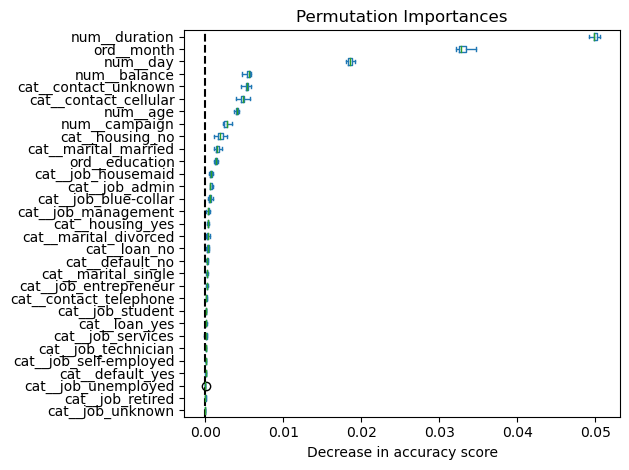

In [111]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator
from typing import Any, Union
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


columns = {
    "numeric": ["age", "balance", "duration", "day", "campaign"],
    "nominal": ["job", "contact", "housing", "marital"],
    "ordinal": ["education", "month"],
}

# ANSWER: LOAN AND DEFAULT DID NOT CONTRIBUTE THAT MUCH TO THE PREDICTIONS (same tendances when looking back to the correlation matrices EDA)
# age : age of customer (numeric)
# job : type of job (categorical)
# marital : marital status (categorical)
# education (categorical)
# balance: average yearly balance, in euros (numeric)
# housing: has a housing loan? (binary)
# contact: contact communication type (categorical)
# day: last contact day of the month (numeric)
# month: last contact month of year (categorical)
# duration: last contact duration, in seconds (numeric)
# campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)


def plot_permutation_importances(
    X: DataFrame,
    y: Union[DataFrame, Any],
    model: BaseEstimator,
    features: List[str],
    n_repeats: int = 10,
    random_state: int = 42,
    n_jobs: int = 2,
) -> None:
    """
    Plot permutation importances for feature importance analysis.

    Args:
        X (DataFrame): Input features.
        y (Union[DataFrame, Any]): Target variable.
        model (BaseEstimator): Model used for feature importance analysis.
        n_repeats (int, optional): Number of times to repeat the permutation. Defaults to 10.
        random_state (int, optional): Random state for reproducibility. Defaults to 42.
        n_jobs (int, optional): Number of parallel jobs to run. Defaults to 2.

    Returns:
        None

    """
    try:
        check_is_fitted(estimator=model)
    except NotFittedError:
        model.fit(X, y)

    result = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=n_jobs
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=np.array(features)[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()


# RUN
plot_permutation_importances(
    model=HistGradientBoostingClassifier(),
    X=data_trans,
    y=data["y"],
    features=preprocessor.get_feature_names_out(),
)

In [174]:
import imblearn

## RE-RUN THE PIPELINE WITH THE MOST IMPORTANT FEATURES TO VALIDATE THEM

columns = {
    "numeric": ["age", "balance", 'duration', 'day', "campaign"],
    "nominal": ["job", "contact", "housing", "marital"], 
    "ordinal": ["education", "month"],
}

fs_preprocessor = create_data_prepocessing_pipeline(**columns)

result = run_experiment(
    data,
    fs_preprocessor,
    eval_metrics=["accuracy", "balanced_accuracy", "f1", "precision", "recall"],
    task='classifier',
    models=[HistGradientBoostingClassifier.__name__],
    additional_steps=[('smote', imblearn.over_sampling.SMOTE(random_state=42))],
    pipeline_func=imblearn.pipeline.make_pipeline,
)
result

['no' 'yes']


100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


,Model,accuracy,balanced_accuracy,f1,precision,recall
0,HistGradientBoostingClassifier,0.930175,0.806369,0.578496,0.513993,0.661601


In [ ]:
# The next steps can be hyperparameters tuning (learning rate, max iter, max depth, l2 regularization)
# But the accuracy (sucess metric) is already above 81%

#### 2. Segment(s) of customers our client should prioritize

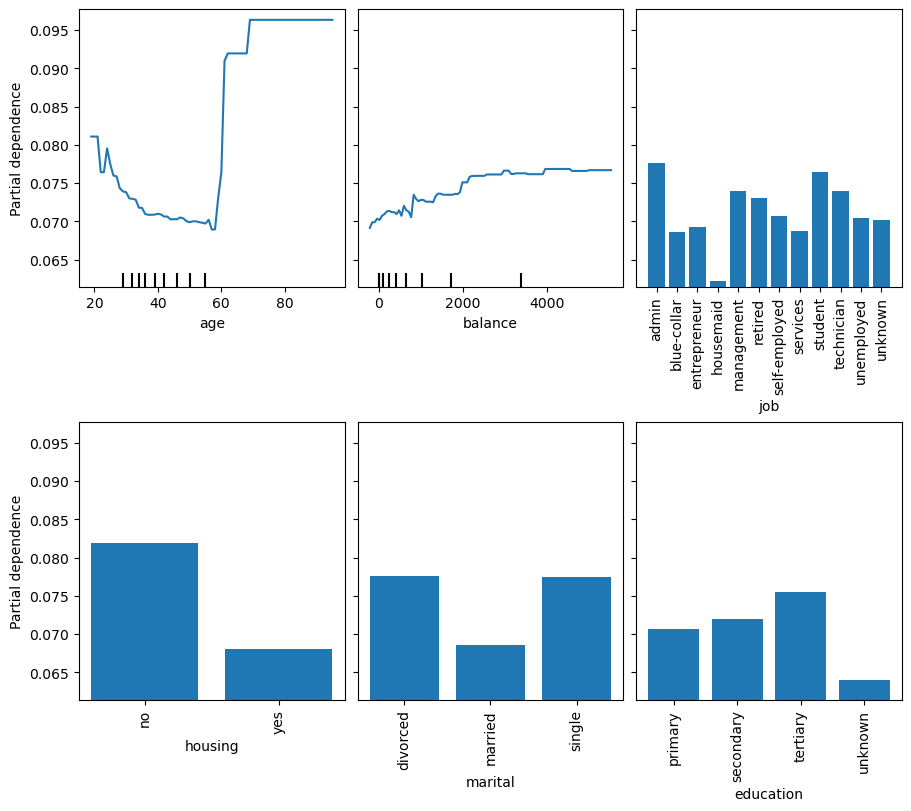

In [179]:
from sklearn.inspection import PartialDependenceDisplay

features_info = {
    # features of interest
    "features": ["age", "balance", "job", "housing", "marital", "education"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features":  columns['nominal'] + columns['ordinal'],
}

X, y = data.drop('y', axis=1), data['y']

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), columns['nominal'] + columns['ordinal']),
        ("num", "passthrough", columns['numeric']),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas") # We can re-run our whole pipeline to test this preprocessing [that suits best DPD Plot] 


hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingClassifier(
        categorical_features=columns['nominal'] + columns['ordinal'],
        random_state=42,
    ),
)
hgbdt_model.fit(X, y)
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X,
    **features_info,
    ax=ax,
)

In [182]:
# ANSWER: From PDP, we can suggest to focus on:
    # age : 
    # >= 60 (mostly older people)
    # job : 
        #(exclude housemaid and consider this top 3)
        # - management
        # - admin
        # - student
    # marital : 
        # - divorced or single 
    # education:
    # - most educated people (prefetertiary)
    # balance:
        # - High
    # housing:
        # - no